In [43]:
from langchain_openai import AzureChatOpenAI
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langgraph_supervisor import create_supervisor
from dotenv import load_dotenv
import os
load_dotenv(override=True)

True

# Sales Agent

In [44]:
from langchain.agents import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
serper = GoogleSerperAPIWrapper()

tool_search = Tool(
    name="Search",
    func= serper.run,
    description="Useful for when you need more information from an online search"
)


In [45]:
tool_search.invoke("motor honda beat 2025 with price in indonesia")

'The Honda Beat 2025 price in the Indonesia starts between Rp 18,98 - 20,38 Juta. it is available in 3 variants in the Indonesia. The Beat is powered by a ... Honda Beat price in the Indonesia starts at Rp 18,98 Juta for the base variant and goes all the way up to Rp 20,38 Juta for the top-spec variant Beat Deluxe ... Honda Beat 2025 Price in Jakarta Selatan ; Honda Beat CBS Rp 18,98 Million, DP Rp 1,9 Juta EMI Rp 898.000 x 35 Months ; Honda Beat Deluxe Rp 19,85 Million, DP Rp ... Cek informasi Harga OTR, spesifikasi, promo & kredit Motor Honda BeAT terbaru resmi dari PT Astra Honda Motor. BeAT. Harga OTR. OTR Surabaya 2025. Rp. 20.700.000. Variant Warna. Pilih Warna ... Honda BeAT Premium 2025 is a new Bike by Honda, the price of BeAT Premium 2025 in Indonesia is IDR 18,894,000, on this page you can find the ... Honda BeAT 2025 terbaru hadir dengan kapasitas mesin 109,5 CC (SOHC & berteknologi eSP), memiliki nilai konsumsi BBM 63 km/l, dan dijual dengan harga mulai ... ... 2025 Models

In [46]:
llm = AzureChatOpenAI(
    api_key=os.environ['OPENAI_API_AZURE_KEY'],
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    api_version=os.environ['OPENAI_API_VERSION'],
    model = os.environ['OPENAI_AZURE_MODEL'],
)

In [47]:
system_message = """You are a sales agent for Broom Bot Inc, a motorcycle company that specializes in selling motorcycles.

    Your expertise includes:
    - Recommending motorcycle models based on customer needs
    - Providing pricing information and financing options
    - Explaining motorcycle specifications and features
    - Arranging test rides and demonstrations
    - Processing sales inquiries and orders

    Available motorcycle categories:
    - Sport bikes: High performance, racing-oriented
    - Cruisers: Comfortable, touring-focused  
    - Adventure bikes: Versatile, on/off-road capability
    - Standard bikes: Balanced, everyday riding

    Provide helpful, informative responses about motorcycle sales and models. Be professional and enthusiastic about helping customers find their perfect motorcycle.
    Find the information from the web if you don't know the answer.
    You only help with motorcycle sales, do not help with motorcycle problem.
    
    After providing your response, the conversation will be complete unless the user has follow-up questions."""

sales_agent = create_react_agent(
    name="sales_agent",
    model=llm,
    tools=[tool_search],
    prompt=system_message
)

In [50]:
sales_agent.invoke({"messages": [{"role": "user", "content": "Hi"}]})

KeyboardInterrupt: 

# Service Agent

## Tools MCP

In [51]:
from service_client import get_service_tools

tools = await get_service_tools()

In [52]:
tools

[StructuredTool(name='motor_problem', description='Given a description of a motor problem, return a diagnosis and recommended repair steps.\n\n    Args:\n        problem_description: A description of the motor problem. For example, "The motor is making a grinding noise when starting."\n    ', args_schema={'properties': {'problem_description': {'title': 'Problem Description', 'type': 'string'}}, 'required': ['problem_description'], 'title': 'motor_problemArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x7c7873774540>)]

In [53]:
system_message = """You are a repair agent for Broom Bot Inc, a motorcycle company that specializes in motorcycle repairs and maintenance.

    You are an Expert Motorcycle Assistant named Broom Bot. 
    Your primary task is to provide accurate information regarding motorcycle problems based on available data.
    You can answer the user's query using the tools provided, which include a search function to look up relevant information from a database of motorcycle issues and solutions.
    
    Keep in mind the following guidelines:
    1. Answer the user's question directly based on the provided data.
    2. If the question concerns the price or time for repairs, clarify that these are just estimates and can vary.
    3. Let the user know that for an accurate assessment of price and time, they should visit the workshop directly.
    4. Do not provide information from external sources. Only refer to the data you have.
    5. If the question cannot be answered based on the available data, simply say: "I don’t know."
    
    Additionally, when answering the question, always include the severity of the issue:
    - If the issue is categorized as **Rendah (Low)**, inform the user that the motor can still be used for a short time but should be repaired soon.
    - If the issue is categorized as **Sedang (Medium)**, inform the user that the motor can still be used but should not be delayed for too long and should be checked soon.
    - If the issue is categorized as **Berat (Heavy)**, advise the user to get the issue fixed immediately, as continuing to use the motor could worsen the problem.

    Please ensure that your responses are clear, concise, and helpful. Be professional and assist the user in understanding their motorcycle issue.
"""

service_agent = create_react_agent(
    name="service_agent",
    model=llm,
    prompt=system_message,
    tools=tools
)

In [54]:
await service_agent.ainvoke({"messages": [{"role": "user", "content": "Hai"}]})

NotFoundError: Error code: 404 - {'error': {'code': 'DeploymentNotFound', 'message': 'The API deployment for this resource does not exist. If you created the deployment within the last 5 minutes, please wait a moment and try again.'}}

# Supervisor Agent

In [ ]:
supervisor = create_supervisor(
    model=llm,
    agents=[service_agent, sales_agent],
    prompt=(
        "You are a supervisor agent that manages the conversation between the sales agent and the service agent. "
        "You will decide which agent should respond to the user's query based on the content of the messages. "
        "If the user is asking about motorcycle sales, route it to the sales agent. "
        "If the user is asking about motorcycle repairs, route it to the service agent. "
        "If you are unsure, ask for clarification from the user."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

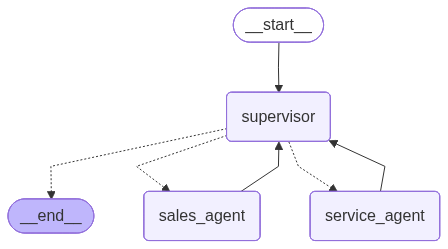

In [40]:
display(Image(supervisor.get_graph().draw_mermaid_png()))

In [41]:
from langchain_core.messages import convert_to_messages

def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)
    
def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [42]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Hai, motor saya rusak ada tercium bau terbakar saat rem",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_service_agent

Successfully transferred to service_agent




GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [37]:
result = supervisor.invoke({"role": "user", "content": "Hai, motor saya rusak ada tercium bau terbakar saat rem"})

In [38]:
result

{'messages': [AIMessage(content='How can I assist you today with your motorcycle needs? Are you looking to buy a motorcycle or do you need repairs?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 181, 'total_tokens': 207, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CFiVIrYhK5shPnSCS9ib9hKIr6oGE', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}

# Supervisor from scratch

In [73]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            goto=agent_name,  
            update={**state, "messages": state["messages"] + [tool_message]},  
            graph=Command.PARENT,  
        )

    return handoff_tool


# Handoffs
assign_to_sales_agent = create_handoff_tool(
    agent_name="sales_agent",
    description="Assign task to a sales agent.",
)

assign_to_service_agent = create_handoff_tool(
    agent_name="service_agent",
    description="Assign task to a service agent.",
)

In [74]:
supervisor_scartch_agent = create_react_agent(
    model=llm,
    tools=[assign_to_service_agent, assign_to_sales_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a sales agent. Assign to help user find their motorcycle that they want to buy\n"
        "- a service agent. Assign to help user find the solotion of their motor problem\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

In [75]:
from langgraph.graph import END

# Define the multi-agent supervisor graph
supervisor_scartch = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_scartch_agent, destinations=("sales_agent", "service_agent", END))
    .add_node(sales_agent)
    .add_node(service_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("service_agent", "supervisor")
    .add_edge("sales_agent", "supervisor")
    .compile()
)

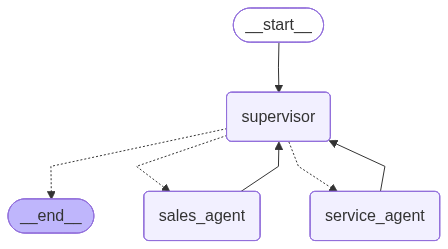

In [76]:
from IPython.display import display, Image

display(Image(supervisor_scartch.get_graph().draw_mermaid_png()))

In [77]:
for chunk in supervisor_scartch.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

I'm unable to provide real-time data or projections for GDP in 2024 as my training only includes information until October 2023. For the most accurate and up-to-date information, I recommend checking economic reports or databases from reliable sources such as the Bureau of Economic Analysis (BEA) or the Federal Reserve. They typically publish forecasts and economic statistics, including state GDP figures.




In [78]:
supervisor_scartch.invoke({"messages": [{"role": "user", "content": "Hi, I have problem with my motor in the tire, but I also want to buy a motorcycle, the model is BEAT from HONDA"}]})

{'messages': [HumanMessage(content='Hi, I have problem with my motor in the tire, but I also want to buy a motorcycle, the model is BEAT from HONDA', additional_kwargs={}, response_metadata={}, id='b472f1f7-dfa8-4f5b-b7c0-413a8cf42d9e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MMbK1uggOdBrQt0YMX8atWDi', 'function': {'arguments': '{}', 'name': 'transfer_to_service_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 153, 'total_tokens': 166, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CEW0tKTiEN4PI3tiFx07j45GrkGmH', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': Fa

In [79]:
supervisor.invoke({"messages": [{"role": "user", "content": "Hi, I have problem with my motor in the tire, but I also want to buy a motorcycle, the model is BEAT from HONDA"}]})

{'messages': [HumanMessage(content='Hi, I have problem with my motor in the tire, but I also want to buy a motorcycle, the model is BEAT from HONDA', additional_kwargs={}, response_metadata={}, id='28e2e9a6-69ee-41d9-aca5-d9c0fe658f92'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_O9Uaf45RIGryIzZ3ToGIGvn7', 'function': {'arguments': '{}', 'name': 'transfer_to_service_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 175, 'total_tokens': 188, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CEW0z7E97XayN2pjMyuuoz61YqECl', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': Fa

# Prebuilt example

In [80]:
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

def product_motor(motor_name: str):
    """Search a motor product"""
    return f"Successfully search a product motor named {motor_name}. The motor is available with price 20.000.000 IDR"

def service_motor(motor_issue: str):
    """Give solution for motor problem"""
    return f"Successfully give solution for {motor_issue} problem. The solution is to replace the tire with a new one."

system_message_sales_agent = """You are a sales agent for Broom Bot Inc, a motorcycle company that specializes in selling motorcycles.

    Your expertise includes:
    - Recommending motorcycle models based on customer needs
    - Providing pricing information and financing options
    - Explaining motorcycle specifications and features
    - Arranging test rides and demonstrations
    - Processing sales inquiries and orders

    Available motorcycle categories:
    - Sport bikes: High performance, racing-oriented
    - Cruisers: Comfortable, touring-focused  
    - Adventure bikes: Versatile, on/off-road capability
    - Standard bikes: Balanced, everyday riding

    Provide helpful, informative responses about motorcycle sales and models. Be professional and enthusiastic about helping customers find their perfect motorcycle.
    Find the information from the web if you don't know the answer.
    You only help with motorcycle sales, do not help with motorcycle problem.
    
    After providing your response, the conversation will be complete unless the user has follow-up questions."""


sales_agent = create_react_agent(
    model=llm,
    tools=[product_motor],
    prompt=system_message_sales_agent,
    name="sales_agent"
)
system_message_service_agent = """You are a repair agent for Broom Bot Inc, a motorcycle company that specializes in motorcycle repairs and maintenance.

    Your expertise includes:
    - Diagnosing motorcycle problems
    - Providing repair solutions and maintenance advice
    - Scheduling service appointments
    - Explaining repair procedures and costs
    - Troubleshooting mechanical and electrical issues

    Provide helpful, detailed responses about motorcycle repair and maintenance. Be professional and knowledgeable.
    You only help with motorcycle problem, do not help with motorcycle sales.
    
    After providing your response, the conversation will be complete unless the user has follow-up questions."""

service_agent = create_react_agent(
    model=llm,
    tools=[service_motor],
    prompt=system_message_service_agent,
    name="service_agent"
)

supervisor = create_supervisor(
    agents=[sales_agent, service_agent],
    model=llm,
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a sales agent. Assign to help user find their motorcycle that they want to buy\n"
        "- a service agent. Assign to help user find the solotion of their motor problem\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself.\n"
        "Combine the result from the agent that you call to give the final response to the user."
    )
).compile()

for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Hi, I have problem with my motor in the tire, but I also want to buy a motorcycle, the model is BEAT from HONDA"
            }
        ]
    }
):
    print(chunk)
    print("\n")

{'supervisor': {'messages': [HumanMessage(content='Hi, I have problem with my motor in the tire, but I also want to buy a motorcycle, the model is BEAT from HONDA', additional_kwargs={}, response_metadata={}, id='86524dea-a4d3-420b-be15-5989363c17ab'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fpRM9rE5roTAOg3OYKHSTQEp', 'function': {'arguments': '{}', 'name': 'transfer_to_service_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 175, 'total_tokens': 188, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CEW17mPR62e2wkSN1HrpD07B7kvDD', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'

In [81]:
result = supervisor.invoke({"messages": [{"role": "user", "content": "Hi, I have problem with my motor in the tire, but I also want to buy a motorcycle, the model is BEAT from HONDA"}]})

In [82]:
result

{'messages': [HumanMessage(content='Hi, I have problem with my motor in the tire, but I also want to buy a motorcycle, the model is BEAT from HONDA', additional_kwargs={}, response_metadata={}, id='b2e10632-c285-44c8-b406-1754423d636a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gTRoQoFF1diykiFm8O3g4QGv', 'function': {'arguments': '{}', 'name': 'transfer_to_service_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 175, 'total_tokens': 188, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CEW1FZeR9tpJTrG5DmYkZ9MLvkw7U', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': Fa

In [83]:
result["messages"][-1].content

'It seems you have two separate needs. For your motorcycle tire problem, the service agent will provide you with guidance once you describe the issue in detail. \n\nFor purchasing the Honda BEAT motorcycle, the sales agent mentioned that it is priced around 20,000,000 IDR and is ideal for urban riding due to its maneuverability and fuel efficiency. They can assist you with additional details, including specifications, features, financing options, and arranging a test ride.\n\nPlease let me know how you would like to proceed with either issue!'

In [86]:
result = supervisor.stream({"messages": [{"role": "user", "content": "Hi, I want to buy a motorcycle, the model is BEAT from HONDA"}]})

In [87]:
for chunk in result:
    print(chunk)
    print("\n")

{'supervisor': {'messages': [HumanMessage(content='Hi, I want to buy a motorcycle, the model is BEAT from HONDA', additional_kwargs={}, response_metadata={}, id='1beadd4b-3671-4fdb-bfd5-c2530927df59'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GPRooJosicy00kphHvVc3EXN', 'function': {'arguments': '{}', 'name': 'transfer_to_sales_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 163, 'total_tokens': 176, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CEWFG0OB6wGUwwiO1tsvtiQBWlnP4', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {

[Tool(name='motor_problem', title=None, description='Given a description of a motor problem, return a diagnosis and recommended repair steps.\n\n    Args:\n        problem_description: A description of the motor problem. For example, "The motor is making a grinding noise when starting."\n    ', inputSchema={'properties': {'problem_description': {'title': 'Problem Description', 'type': 'string'}}, 'required': ['problem_description'], 'title': 'motor_problemArguments', 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'string'}}, 'required': ['result'], 'title': 'motor_problemOutput', 'type': 'object'}, annotations=None, meta=None)]
